#### Human loop

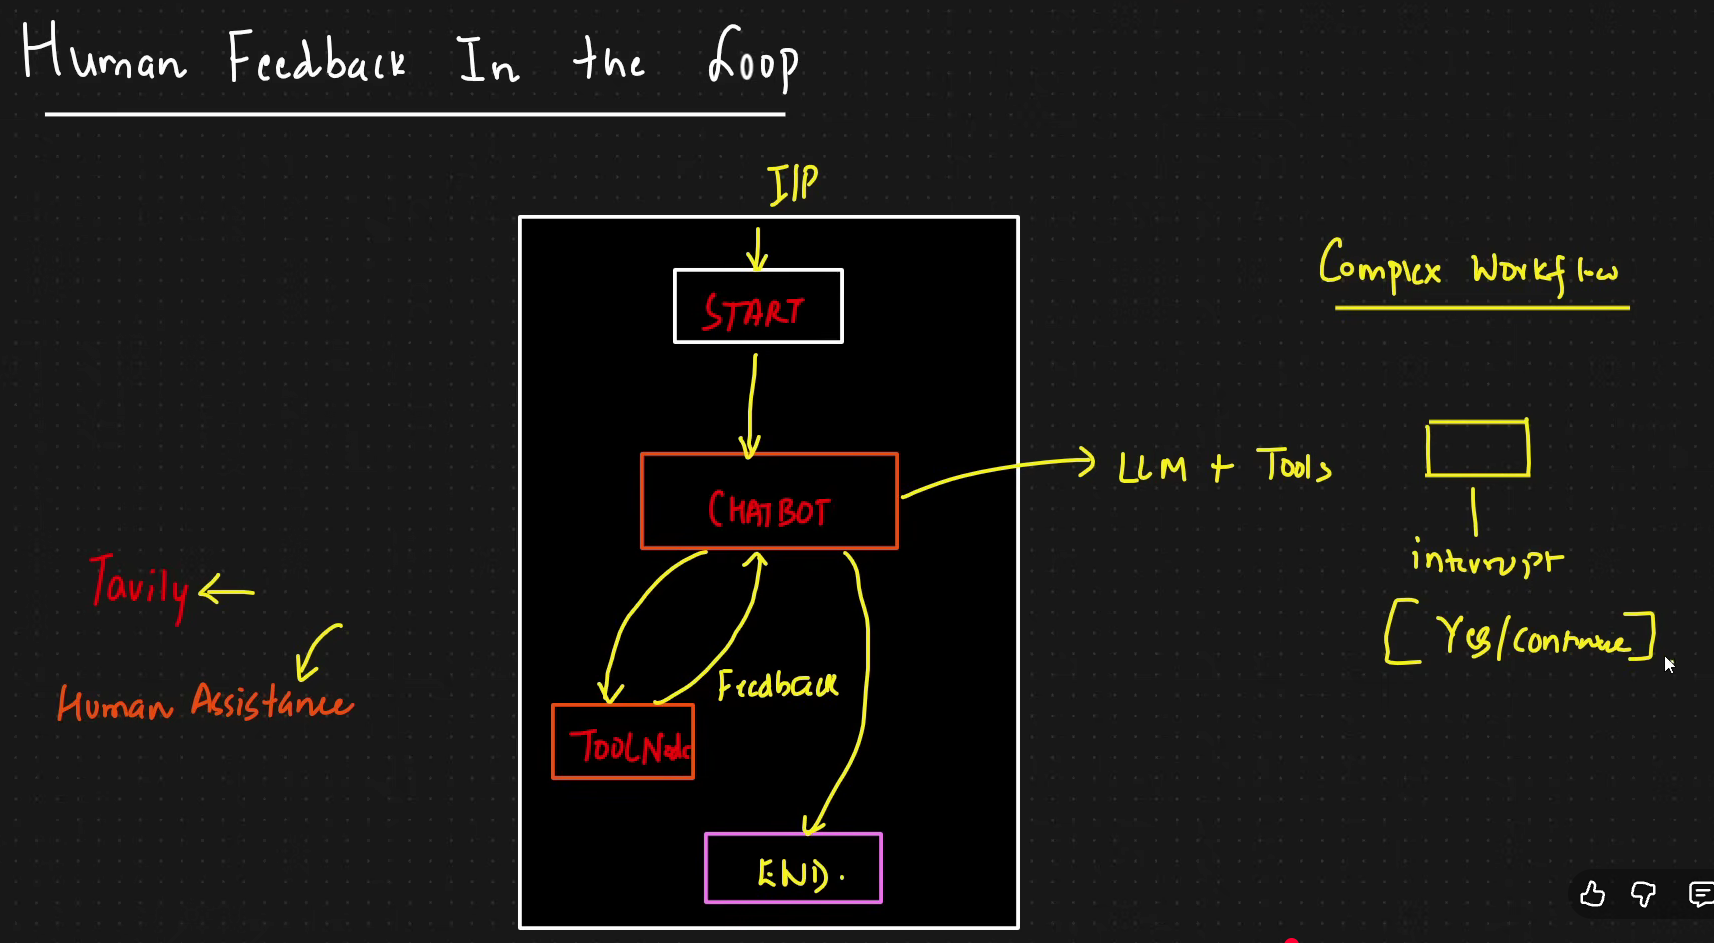

In [7]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama-3.1-8b-instant")
llm.invoke('What is python?')

AIMessage(content='**What is Python?**\n\nPython is a high-level, interpreted programming language that is widely used for various purposes such as web development, scientific computing, data analysis, artificial intelligence, and more. It was created in the late 1980s by Guido van Rossum and was first released in 1991.\n\n**Key Features of Python:**\n\n1. **Easy to Learn:** Python has a simple syntax and is relatively easy to read and write, making it a great language for beginners.\n2. **High-Level Language:** Python is a high-level language, meaning it abstracts away many low-level details, allowing developers to focus on the logic of the program without worrying about memory management and other details.\n3. **Interpreted Language:** Python code is interpreted at runtime, which means that it does not need to be compiled before execution.\n4. **Object-Oriented:** Python is an object-oriented language, which means it supports the concept of objects, classes, and inheritance.\n5. **La

In [8]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

@tool
def human_assistance(query: str) -> str:
    """Request assiatance from human"""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chat_bot(state:State):
        #return {"messages":[llm.invoke(state['messages'])]}
        message = llm_with_tools.invoke(state["messages"])
        return {"messages":[message]}

graph_builder.add_node('chat_bot',chat_bot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chat_bot",
    tools_condition
)


graph_builder.add_edge(START, 'chat_bot')
#graph_builder.add_edge('chat_bot','tools')
graph_builder.add_edge('tools', 'chat_bot')


#graph = graph_builder.compile()

#display(Image(graph.get_graph().draw_mermaid_png()))

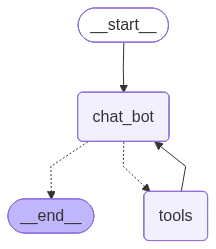

In [9]:
mem_saver = MemorySaver()
graph = graph_builder.compile(checkpointer=mem_saver)
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
user_input = "I need some expert guidence and assistance for building an AI agent . Could you request assistance fro me?"
config = {"configurable":{"thread_id":"1"}}

events = graph.stream(
    {'messages':user_input},
    config=config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidence and assistance for building an AI agent . Could you request assistance fro me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (segx3dhgt)
 Call ID: segx3dhgt
  Args:
    query: expert guidance and assistance for building a conversational AI agent with LangGraph and current AI trends and real-world applications
================================== Ai Message ==================================
Tool Calls:
  human_assistance (segx3dhgt)
 Call ID: segx3dhgt
  Args:
    query: expert guidance and assistance for building a conversational AI agent with LangGraph and current AI trends and real-world applications


In [22]:
human_response = (
    "We the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "Itts's musch more reliable and extnesible than simple autonomous agents."
)

human_cmd = Command(resume={"data":human_response})

events = graph.stream(human_cmd, config=config, stream_mode='values')
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (segx3dhgt)
 Call ID: segx3dhgt
  Args:
    query: expert guidance and assistance for building a conversational AI agent with LangGraph and current AI trends and real-world applications
================================= Tool Message =================================
Name: human_assistance

We the experts are here to help! We'd recommend you check out LangGraph to build your agent.Itts's musch more reliable and extnesible than simple autonomous agents.
================================== Ai Message ==================================

It seems that the expert guidance and assistance you requested is already being provided.
